In [1]:
import torch as tc
tc.set_default_tensor_type(tc.DoubleTensor)

In [2]:
from __future__ import division
import sys, platform, os

import numpy as np
import scipy as sp
from scipy.optimize import root

# import MyHyperSphericaljl as jl
# import MyOtherFunctions as fun

import matplotlib
from matplotlib import pyplot as plt
%matplotlib inline

In [3]:
import camb
from camb import model, initialpower
print('Using CAMB %s installed at %s'%(camb.__version__,os.path.dirname(camb.__file__)))

Using CAMB 1.5.4 installed at /opt/anaconda3/envs/py38/lib/python3.8/site-packages/camb


In [4]:
h = 0.673
ns = 0.966
As = 2e-9
ks = 0.05 # 1/Mpc
c_light = 2.99792458e5 # m/s
l_max = 2000


In [5]:
beta_flat = np.hstack([10**np.linspace(-5, -2, 1500, endpoint=False), np.arange(1e-2, 8e-1, 1e-4)])
beta_open = np.hstack([10**np.linspace(-8, -6, 1000, endpoint=False), 10**np.linspace(-6, -2, 2000, endpoint=False), np.arange(1e-2, 8e-1, 1e-4)])
nu_closed = np.arange(3, 14000, 1)

OmegaK_open = 0.05
Kscale_open = np.sqrt(np.abs((h*100/c_light)**2 * OmegaK_open)) # 1/Mpc
k_open = np.sqrt(beta_open**2 + Kscale_open**2)

OmegaK_closed = -0.05
Kscale_closed = np.sqrt(np.abs((h*100/c_light)**2 * OmegaK_closed)) # 1/Mpc
k_closed = Kscale_closed * np.sqrt(nu_closed**2 - 1)


k_flat = tc.tensor(beta_flat)
k_open = tc.tensor(k_open)
k_closed = tc.tensor(k_closed)
k_array = [k_flat, k_open, k_closed]

beta_flat = tc.tensor(beta_flat)
beta_open = tc.tensor(beta_open)
beta_closed = tc.tensor(nu_closed * Kscale_closed)
beta_array = [beta_flat, beta_open, beta_closed]

l_array = tc.arange(l_max)

In [6]:
def My_Integral(x, y, s):
    '''
        s=True      trapzoidal
        s=False     summation
    '''
    if s:
        dx = x[1:] - x[:-1]
        ymean = (y[:, 1:] + y[:, :-1]) / 2
        return tc.sum(dx * ymean, dim=(1))
    else:
        return tc.sum(tc.ones_like(x) * y * Kscale_closed, dim=(1))

In [9]:
geometry = ['flat', 'open', 'closed']
gamma_GW = 1.8
fNL = -1. #-0.1

Total_l = tc.empty([3, l_max])
SW_l = tc.empty([3, l_max])
ISW_l = tc.empty([3, l_max])
slist = [True, True, False]

for i in range(3):
    g = geometry[i]
    jl_SW = tc.tensor(np.load('HyperSpherical_jl_' + g + '.npy'))
    Tl_ISW = 2 * tc.tensor(np.load('Tl_l2000_' + g + '.npy'))

    if i==1:
        jl_SW_qsmall = tc.tensor(np.load('HyperSpherical_jl_open_qsmall.npy'))
        Tl_ISW_qsmall = 2 * tc.tensor(np.load('Tl_l2000_open_qsmall.npy'))

        jl_SW = tc.vstack([jl_SW_qsmall, jl_SW])
        Tl_ISW = tc.vstack([Tl_ISW_qsmall, Tl_ISW])
    elif i==2 :
        jl_SW_beta34 = tc.tensor(np.load('HyperSpherical_jl_closed_beta34.npy'))
        Tl_ISW_beta34 = 2 * tc.tensor(np.load('Tl_l2000_closed_beta34.npy'))

        jl_SW = tc.vstack([jl_SW_beta34, jl_SW])
        Tl_ISW = tc.vstack([Tl_ISW_beta34, Tl_ISW])
    
    print('The number of modes with ' + g + ' is ', len(jl_SW))

    T_SW = l_array * (l_array + 1) * jl_SW**2
    T_SW = T_SW.T * (k_array[i]**(ns - 3)) * beta_array[i]
    T_SW = (1 - 2/(4 - gamma_GW))**2 * T_SW
    # T_NAD = (36/5 * fNL /(4 - gamma_GW))**2 * T_SW


    T_ISW = l_array * (l_array + 1) * Tl_ISW**2
    T_ISW = T_ISW.T * (k_array[i]**(ns - 3)) * beta_array[i]

    T_tot = ((1  + (36/5 * fNL - 2)/(4 - gamma_GW))) * jl_SW + Tl_ISW
    T_tot = l_array * (l_array + 1) * T_tot**2
    T_tot = T_tot.T * (k_array[i]**(ns - 3)) * beta_array[i]

    Dl_SW = My_Integral(beta_array[i], T_SW, slist[i]) * As * ks**(1-ns) * 4/9 * 2 # * 4 * tc.pi 
    Dl_ISW = My_Integral(beta_array[i], T_ISW, slist[i]) * As * ks**(1-ns) * 4/9 * 2 # * 4 * tc.pi 
    Dl_tot = My_Integral(beta_array[i], T_tot, slist[i]) * As * ks**(1-ns) * 4/9 * 2 # * 4 * tc.pi 

    SW_l[i] = Dl_SW
    ISW_l[i] = Dl_ISW
    Total_l[i] = Dl_tot

The number of modes with flat is  9400
The number of modes with open is  10900
The number of modes with closed is  13997


In [8]:
np.save('GWB_fm01_Dl.npy', np.array(Total_l))

In [10]:
np.save('GWB_fm1_Dl.npy', np.array(Total_l))

In [8]:
pars_flat = camb.set_params(H0=100*h, ombh2=0.0223828, omch2=0.1201075, mnu=6.451439e-04, omk=0, tau=0.05430842, As=As, ns=ns, halofit_version='mead', lmax=l_max)
pars_open = camb.set_params(H0=100*h, ombh2=0.0223828, omch2=0.1201075, mnu=6.451439e-04, omk=OmegaK_open, tau=0.05430842, As=As, ns=ns, halofit_version='mead', lmax=l_max)
pars_closed = camb.set_params(H0=100*h, ombh2=0.0223828, omch2=0.1201075, mnu=6.451439e-04, omk=OmegaK_closed, tau=0.05430842, As=As, ns=ns, halofit_version='mead', lmax=l_max)

pars_set = [pars_flat, pars_open, pars_closed]
totDl = tc.empty([3, l_max])

for i in range(3):
    pars = pars_set[i]
    CMB_results = camb.get_results(pars)
    powers = CMB_results.get_cmb_power_spectra(pars)

    print('The shape of powers from CAMB is ', powers['total'].shape)
    Dl = tc.tensor(powers['total'])[:l_max, 0]
    totDl[i] = Dl

The shape of powers from CAMB is  (2051, 4)
The shape of powers from CAMB is  (2047, 4)
The shape of powers from CAMB is  (2031, 4)


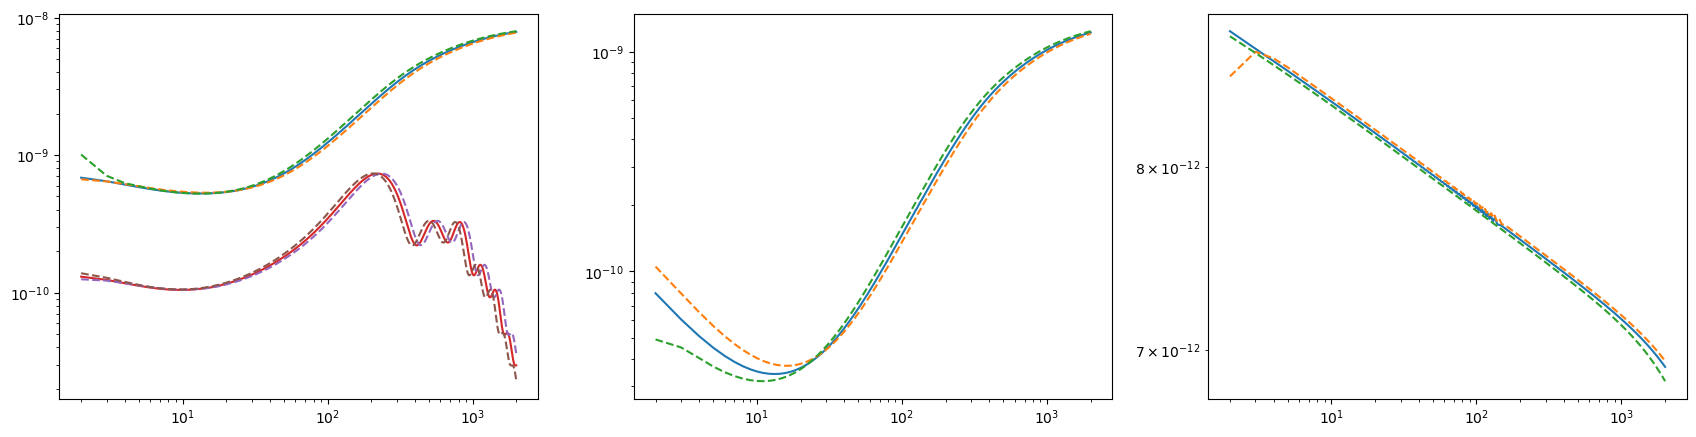

In [9]:
lstart = 2
lend = -1

fig = plt.figure(figsize=(21,5))

plt.subplot(131)
plt.loglog(l_array[lstart:lend], Total_l[0, lstart:lend] * 2 * tc.pi, '-', label=r'$D_l^{\mathrm{GWB}}$ with $K=0$ (flat universe)')
plt.loglog(l_array[lstart:lend], Total_l[1, lstart:lend] * 2 * tc.pi, '--', label=r'$D_l^{\mathrm{GWB}}$ with $K<0$ (open universe)')
plt.plot(l_array[lstart:lend], Total_l[2, lstart:lend] * 2 * tc.pi, '--', label=r'$D_l^{\mathrm{GWB}}$ with $K>0$ (closed universe)')
plt.loglog(l_array[lstart:lend], totDl[0, lstart:lend], '-', label=r'$D_l^{\mathrm{CMB}}$ with $K=0$ (flat universe)')
plt.loglog(l_array[lstart:lend], totDl[1, lstart:lend], '--', label=r'$D_l^{\mathrm{CMB}}$ with $K<0$ (open universe)')
plt.loglog(l_array[lstart:lend], totDl[2, lstart:lend], '--', label=r'$D_l^{\mathrm{CMB}}$ with $K>0$ (closed universe)')
# plt.legend()

plt.subplot(132)
plt.loglog(l_array[lstart:lend], ISW_l[0, lstart:lend], '-')
plt.loglog(l_array[lstart:lend], ISW_l[1, lstart:lend], '--')
plt.loglog(l_array[lstart:lend], ISW_l[2, lstart:lend], '--')

plt.subplot(133)
plt.loglog(l_array[lstart:lend], SW_l[0, lstart:lend], '-')
plt.loglog(l_array[lstart:lend], SW_l[1, lstart:lend], '--')
plt.loglog(l_array[lstart:lend], SW_l[2, lstart:lend], '--')

plt.show()

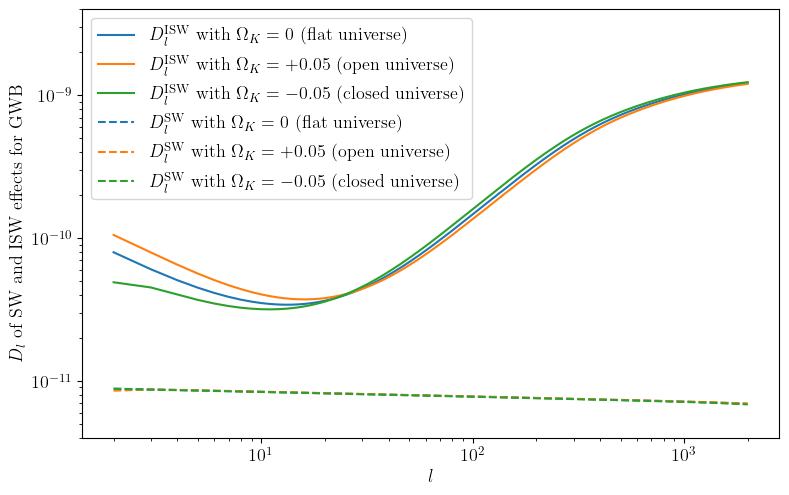

In [10]:
lstart = 2
lend = -1

fig = plt.figure(figsize=(9, 5.5623))

plt.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
    "font.serif": ["Times New Roman"],
    "font.size": 13,
})

# plt.plot(l_array[lstart:lend], ISW_l[0, lstart:lend], '-', label=r'$D_l^{\mathrm{ISW}}$ with $\Omega_K=0$ (flat universe)')
# plt.plot(l_array[lstart:lend], ISW_l[1, lstart:lend], '--', label=r'$D_l^{\mathrm{ISW}}$ with $\Omega_K=+0.05$ (open universe)')
# plt.plot(l_array[lstart:lend], ISW_l[2, lstart:lend], '--', label=r'$D_l^{\mathrm{ISW}}$ with $\Omega_K=-0.05$ (closed universe)')
# plt.plot(l_array[lstart:lend], SW_l[0, lstart:lend], '-', label=r'$D_l^{\mathrm{SW}}$ with $\Omega_K=0$ (flat universe)')
# plt.plot(l_array[lstart:lend], SW_l[1, lstart:lend], '--', label=r'$D_l^{\mathrm{SW}}$ with $\Omega_K=+0.05$ (open universe)')
# plt.plot(l_array[lstart:lend], SW_l[2, lstart:lend], '--', label=r'$D_l^{\mathrm{SW}}$ with $\Omega_K=-0.05$ (closed universe)')

plt.plot(l_array[lstart:lend], ISW_l[0, lstart:lend], '-', c='#1f77b4', label=r'$D_l^{\mathrm{ISW}}$ with $\Omega_K=0$ (flat universe)')
plt.plot(l_array[lstart:lend], ISW_l[1, lstart:lend], '-', c='#ff7f0e', label=r'$D_l^{\mathrm{ISW}}$ with $\Omega_K=+0.05$ (open universe)')
plt.plot(l_array[lstart:lend], ISW_l[2, lstart:lend], '-', c='#2ca02c', label=r'$D_l^{\mathrm{ISW}}$ with $\Omega_K=-0.05$ (closed universe)')
plt.plot(l_array[lstart:lend], SW_l[0, lstart:lend], '--', c='#1f77b4', label=r'$D_l^{\mathrm{SW}}$ with $\Omega_K=0$ (flat universe)')
plt.plot(l_array[lstart:lend], SW_l[1, lstart:lend], '--', c='#ff7f0e', label=r'$D_l^{\mathrm{SW}}$ with $\Omega_K=+0.05$ (open universe)')
plt.plot(l_array[lstart:lend], SW_l[2, lstart:lend], '--', c='#2ca02c', label=r'$D_l^{\mathrm{SW}}$ with $\Omega_K=-0.05$ (closed universe)')

plt.xscale('log')
plt.yscale('log')
plt.ylim([4e-12,4e-9])

plt.xlabel(r'$l$', usetex=True)
plt.ylabel(r'$D_l$ of SW and ISW effects for GWB', usetex=True)
plt.legend()

plt.savefig('SW_and_ISW_NAD.pdf')

plt.show()

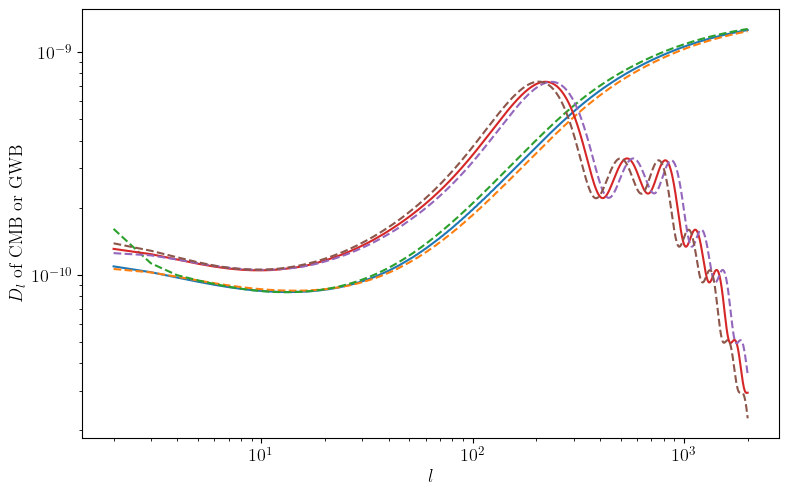

In [11]:
lstart = 2
lend = -1


fig = plt.figure(figsize=(9, 5.5623), dpi=100)

plt.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
    "font.serif": ["Times New Roman"],
    "font.size": 13,
})


plt.plot(l_array[lstart:lend], Total_l[0, lstart:lend], '-', label=r'$D_l^{\mathrm{GWB}}$ with $\Omega_K=0$ (flat universe)')
plt.plot(l_array[lstart:lend], Total_l[1, lstart:lend], '--', label=r'$D_l^{\mathrm{GWB}}$ with $\Omega_K=+0.05$ (open universe)')
plt.plot(l_array[lstart:lend], Total_l[2, lstart:lend], '--', label=r'$D_l^{\mathrm{GWB}}$ with $\Omega_K=-0.05$ (closed universe)')
plt.plot(l_array[lstart:lend], totDl[0, lstart:lend], '-',  label=r'$D_l^{\mathrm{CMB}}$ with $\Omega_K=0$ (flat universe)')
plt.plot(l_array[lstart:lend], totDl[1, lstart:lend], '--', label=r'$D_l^{\mathrm{CMB}}$ with $\Omega_K=+0.05$ (open universe)')
plt.plot(l_array[lstart:lend], totDl[2, lstart:lend], '--', label=r'$D_l^{\mathrm{CMB}}$ with $\Omega_K=-0.05$ (closed universe)')

plt.xscale('log')
plt.yscale('log')
# plt.ylim([1e-11,1e-8])

plt.xlabel(r'$l$', usetex=True)
plt.ylabel(r'$D_l$ of CMB or GWB', usetex=True)
# plt.legend()

plt.savefig('Dl_GWB_CMB_NAD.pdf')

plt.show()